## First calculate MCMC posterior predictions

In [ ]:
%pylab inline
from skmonaco import mcmiser
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_mcmc_quick
from Chempy.score_function import preload_params_mcmc
from Chempy.plot_mcmc import restructure_chain
a = ModelParameters()
preload = preload_params_mcmc()

In [ ]:
from Chempy.wrapper import single_star_optimization
%timeit -r 1 -n 1 single_star_optimization()


In [ ]:
restructure_chain('mcmc/')
positions = np.load('mcmc/posteriorPDF.npy')
init_param = []
for j in range(len(a.p0)):
    init_param.append(np.percentile(positions[:,j],50))
print(init_param)

In [ ]:
# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post,_ = posterior_function_mcmc_quick(theta,a,preload)
    posterior = np.exp(post)
    return posterior

sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
sigma = np.array(sigma)

In [ ]:
Nsamples = [10000,10000,100000] # No MC samples
Nsigma = [2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []
for i in range(len(Nsigma)):
    print('Calculating integral %d of %d' %(i+1,len(Nsigma)))
    result,error = mcmiser(posterior,npoints=Nsamples[j],xl=init_param-Nsigma[i]*sigma,xu=init_param+Nsigma[i]*sigma)
    integral.append(result)
    integral_err.append(error)

In [ ]:
plt.errorbar(Nsigma,integral,yerr=integral_err)

In [ ]:
ratio = posterior(init_param)/posterior(init_param+sigma)
print(ratio)

In [ ]:
factor = np.sqrt(1./np.log(ratio)*np.dot(sigma,sigma.T)/2)

In [ ]:
d1 = []
d2 = []
d3 = []
from scipy.stats import norm
Nsigma = 3
for i in range(5000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    post,_ = posterior_function_mcmc_quick(param,a,preload)
    posterior = np.exp(post)
    d1.append(param[0])
    d2.append(param[1])
    dis = np.sqrt(np.dot(param-init_param,(param-init_param).T))
    d3.append(posterior/norm.pdf(dis,scale=0.18))
    if i%100==0:
        print(i)


In [ ]:
plt.scatter(d1,d2,c=(d3),vmax=0.005)
plt.colorbar()

In [ ]:
from skmonaco import mcimport
skmonaco.mcimport(posterior(theta), npoints, distribution, args=(), dist_kwargs={}, rng=None, nprocs=1, seed=None, batch_size=None, weight=1.0)

In [ ]:
plt.errorbar(Nsigma,integral,yerr=integral_err)

In [ ]:
#factor = scinorm(a.p0,mean=init_param,cov=cov)
init_param

In [ ]:
posterior_mod(init_param+np.array([0.1,0.1,0.1,0.1,0.1,0.1]))

In [ ]:
posterior_mod(init_param)

In [ ]:
Nsigma = 3
d1 = []
d2 = []
d3 = []
for i in range(5000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    posterior2 = posterior_mod(param)
    d1.append(param[0])
    d2.append(param[1])
    d3.append(posterior2)
    if i%100==0:
        print(i)


In [ ]:
plt.scatter(d1,d2,c=(d3))
plt.colorbar()

In [ ]:
cov = np.zeros((len(init_param),len(init_param)))
for i in range(len(init_param)):
    param = np.copy(init_param)
    param[i] = init_param[i]+sigma[i] # Change by 1 sigma in this direction
    factor = posterior(np.array(init_param))/posterior(np.array(param))
    cov[i,i] = np.sqrt(sigma[i]**2/(2*np.log(factor)))

In [5]:
restructure_chain('mcmc/')
positions = np.load('mcmc/posteriorPDF.npy')
init_param = []
for j in range(len(a.p0)):
    init_param.append(np.percentile(positions[:,j],50))
print(init_param)

blob shape =  (64, 303, 28, 1) probably some runs did not return results and were stored anyway.
The chain has a length of 303 iterations, each iteration having 64 evaluations/walkers
Mean posteriors at the beginning and the end of the chain:
-6.20198206318 -16.1270111454
Mean posteriors after the burn-in tail is cut out:
-6.20198206318 -6.02938802047
We are left with a sample of 4992 posterior evaluations from the converged MCMC chain
We have 4992 iterations good enough posterior, their posteriors range from
-3.3583772798 -14.5414302898
Highest posterior was obtained at parameters:  [[-2.39743005 -3.00094579 -0.7196173  -0.29756725  0.53552653  0.50570946]]
Number of unique posterior values:  2607
Inferred marginalized parameter distributions are:
0 -2.31548686528 +- 0.14781494545
1 -2.91227645502 +- 0.190944241625
2 -0.770900092276 +- 0.298558270751
3 -0.263359328175 +- 0.291731942072
4 0.563763436811 +- 0.0963926043164
5 0.503290693195 +- 0.093505369776
[-2.3052232065318243, -2.9027

In [6]:
%pylab inline
#from skmonaco import mcmiser
from Chempy.parameter import ModelParameters
from Chempy.cem_function import posterior_function_mcmc_quick
from Chempy.score_function import preload_params_mcmc
from Chempy.plot_mcmc import restructure_chain
a = ModelParameters()
preload = preload_params_mcmc()

Populating the interactive namespace from numpy and matplotlib


/home/philcox/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [37]:
sigma = [] # Read prior sigma from parameter file
for i,param_name in enumerate(a.to_optimize):
    sigma.append(a.priors.get(param_name)[1])
sigma = np.array(sigma)

Nsigma_width=4
widening = 1 # 50% wider gaussian distribution
cov = np.zeros((len(init_param),len(init_param)))
for i in range(len(init_param)):
    param = np.copy(init_param)
    param[i] = np.copy(init_param[i])+Nsigma_width*sigma[i] # Change by 1 sigma in this direction
    factor = posterior(np.array(init_param))/posterior(np.array(param))
    cov[i,i] = (widening*Nsigma_width*sigma[i])**2/(2*np.log(factor)) # np.sqrt()?
# Using 2 sigma at moment, 1.21 factor widens it slightly by 10% to ensure gaussian is wider than posterior

In [38]:
cov

array([[ 0.02619771,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.02879028,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.08367257,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.08598433,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00947444,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00869105]])

In [39]:
from scipy.stats import multivariate_normal as scinorm
from numpy.random import multivariate_normal as numnorm

# Define function to return posterior predictions (must be exponentiated)
def posterior(theta):
    a = ModelParameters()
    post,_ = posterior_function_mcmc_quick(theta,a,preload)
    posterior = np.exp(post)
    return posterior

def posterior_mod(theta):
    return posterior(theta)/gauss_factor(theta)

def gauss_factor(theta):
    return scinorm.pdf(theta,mean=np.array(init_param),cov=cov)

def dist(size):
    # Distribution function
    mean = np.array(init_param)
    return numnorm(mean,cov,size=size)

# factor is the width of the posterior distribution....

In [17]:
from skmonaco import mcimport
Nsamples = [500,1000, 5000] # No MC samples
#Nsigma = [2,2.5,3,3.5] # Width in parameter space
j = 0
integral = []
integral_err = []

for j in range(len(Nsamples)):
    print('Calculating integral %d of %d' %(j+1,len(Nsamples)))
    result,error = mcimport(posterior_mod,Nsamples[j],dist)
    integral.append(result)
    integral_err.append(error)

Calculating integral 1 of 3
Calculating integral 2 of 3
Calculating integral 3 of 3


<Container object of 3 artists>

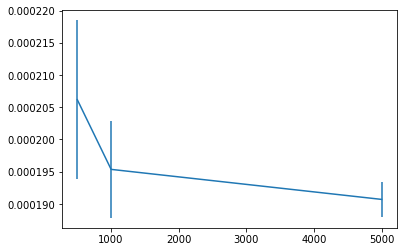

In [19]:
plt.errorbar(Nsamples,integral,yerr=integral_err)

In [40]:
Nsigma = 3
x=[]
y=[]
post=[]
gauss = []
for i in range(2000):
    param = random.uniform(np.array(init_param)-Nsigma*np.array(sigma),np.array(init_param)+Nsigma*np.array(sigma),size=6)
    #param[1] = init_param[1]
    param[2] = init_param[2]
    param[3] = init_param[3]
    param[4] = init_param[4]
    param[5] = init_param[5]
    x.append(param[0])
    y.append(param[1])
    post.append(posterior(param))
    gauss.append(gauss_factor(param))
    if i%500==0:
        print(i)


0
500
1000
1500


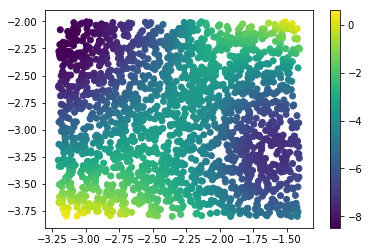

In [44]:
plt.clf()
plt.scatter(x,y,c=np.log10(np.array(post)/np.array(gauss)))
plt.colorbar()
#plt.scatter(x,np.log(post/max(post)),c='r')
#plt.scatter(x,np.log(gauss/max(gauss)),c='b')
#plt.scatter(x,np.log(np.array(post)/np.array(gauss)/max(post)*max(gauss)),c='g')
#plt.xlim([-1.6,-1.5])
#max(post)